Assignment2 Model training without preprocessing data

In [ ]:
# imports + load original dataset
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc)

sns.set_style("whitegrid")
df_raw = pd.read_csv("Diabetes_dataset.csv")   # file in same folder
print("Shape:", df_raw.shape)
print("Any nulls:\n", df_raw.isnull().sum())
print("Zero counts (Glucose,BP,Skin,Insulin,BMI):")
print((df_raw[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]] == 0).sum())
df_raw.head()


Shape: (300, 8)
Any nulls:
 Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
Age              0
Outcome          0
dtype: int64
Zero counts (Glucose,BP,Skin,Insulin,BMI):
Glucose            2
BloodPressure     12
SkinThickness     92
Insulin          152
BMI                5
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
0,6,148,72,35,0,33.6,50,1
1,1,85,66,29,0,26.6,31,0
2,8,183,64,0,0,23.3,32,1
3,1,89,66,23,94,28.1,21,0
4,0,137,40,35,168,43.1,33,1


Applying logostic regression on this raw data

In [2]:
# CELL 2: split raw data and train logistic regression (raw)
X = df_raw.drop("Outcome", axis=1)
y = df_raw["Outcome"]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

lr_raw = LogisticRegression(max_iter=1000, random_state=42)
lr_raw.fit(X_train_raw, y_train)

y_pred_raw = lr_raw.predict(X_test_raw)
y_prob_raw = lr_raw.predict_proba(X_test_raw)[:,1]
print("Trained Logistic Regression (raw).")


Trained Logistic Regression (raw).


Raw metrics: {'acc': 0.683, 'prec': 0.577, 'recall': 0.652, 'f1': 0.612, 'auc': 0.794}


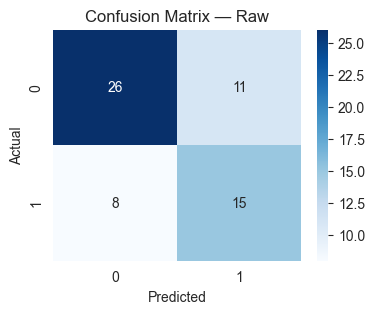

In [ ]:
# metrics + confusion matrix for raw model
def metrics_dict(y_true, y_pred, y_prob):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "prec": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": roc_auc_score(y_true, y_prob)
    }

m_raw = metrics_dict(y_test, y_pred_raw, y_prob_raw)
print("Raw metrics:", {k: round(v,3) for k,v in m_raw.items()})

cm_raw = confusion_matrix(y_test, y_pred_raw)
plt.figure(figsize=(4,3)); sns.heatmap(cm_raw, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Raw"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()


ROC CURVE FOR RAW DATA MODELING

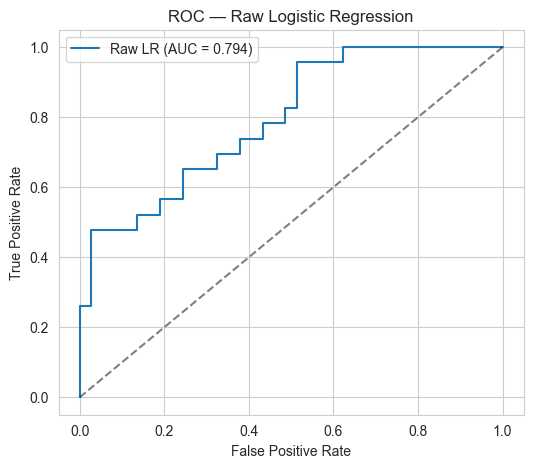

In [5]:
#  ROC curve for raw model
fpr_raw, tpr_raw, _ = roc_curve(y_test, y_prob_raw)
plt.figure(figsize=(6,5))
plt.plot(fpr_raw, tpr_raw, label=f"Raw LR (AUC = {m_raw['auc']:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Raw Logistic Regression"); plt.legend(); plt.show()


Preprocessing the data

In [6]:
#  preprocessing pipeline (train-only fitting)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler

zero_cols = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

# copies so raw X_train_raw / X_test_raw remain unchanged
Xtr = X_train_raw.copy(); Xte = X_test_raw.copy()

# 1) replace impossible zeros with NaN (so they are treated as missing)
Xtr[zero_cols] = Xtr[zero_cols].replace(0, np.nan)
Xte[zero_cols] = Xte[zero_cols].replace(0, np.nan)

# 2) median impute (fit on train)
imp = SimpleImputer(strategy="median")
Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xte_imp = pd.DataFrame(imp.transform(Xte), columns=Xte.columns, index=Xte.index)

# 3) IQR capping (compute from train, apply to both)
Q1 = Xtr_imp.quantile(0.25); Q3 = Xtr_imp.quantile(0.75); IQR = Q3 - Q1
low = Q1 - 1.5 * IQR; high = Q3 + 1.5 * IQR
Xtr_cap = Xtr_imp.clip(lower=low, upper=high, axis=1)
Xte_cap = Xte_imp.clip(lower=low, upper=high, axis=1)

# 4) power transform (Yeo-Johnson) and 5) standard scale (fit on train)
pt = PowerTransformer(method="yeo-johnson")
Xtr_pt = pd.DataFrame(pt.fit_transform(Xtr_cap), columns=Xtr_cap.columns, index=Xtr_cap.index)
Xte_pt = pd.DataFrame(pt.transform(Xte_cap), columns=Xte_cap.columns, index=Xte_cap.index)

sc = StandardScaler()
Xtr_pre = pd.DataFrame(sc.fit_transform(Xtr_pt), columns=Xtr_pt.columns, index=Xtr_pt.index)
Xte_pre = pd.DataFrame(sc.transform(Xte_pt), columns=Xte_pt.columns, index=Xte_pt.index)

print("Preprocessing finished. Any NaNs left (train,test):", Xtr_pre.isna().sum().sum(), Xte_pre.isna().sum().sum())


Preprocessing finished. Any NaNs left (train,test): 0 0


Traing tha model

Preprocessed metrics: {'acc': 0.633, 'prec': 0.52, 'recall': 0.565, 'f1': 0.542, 'auc': 0.776}


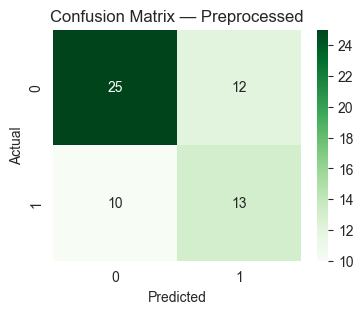

In [7]:
# train & eval logistic regression on preprocessed data
lr_pre = LogisticRegression(max_iter=1000, random_state=42)
lr_pre.fit(Xtr_pre, y_train)

y_pred_pre = lr_pre.predict(Xte_pre)
y_prob_pre = lr_pre.predict_proba(Xte_pre)[:,1]

m_pre = metrics_dict(y_test, y_pred_pre, y_prob_pre)
print("Preprocessed metrics:", {k: round(v,3) for k,v in m_pre.items()})

cm_pre = confusion_matrix(y_test, y_pred_pre)
plt.figure(figsize=(4,3)); sns.heatmap(cm_pre, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Preprocessed"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()


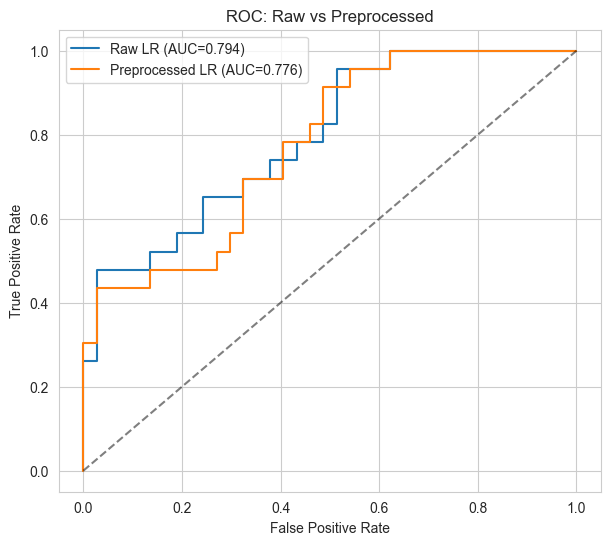

In [8]:
# ROC comparison (raw vs preprocessed)
fpr_pre, tpr_pre, _ = roc_curve(y_test, y_prob_pre)

plt.figure(figsize=(7,6))
plt.plot(fpr_raw, tpr_raw, label=f"Raw LR (AUC={m_raw['auc']:.3f})")
plt.plot(fpr_pre, tpr_pre, label=f"Preprocessed LR (AUC={m_pre['auc']:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC: Raw vs Preprocessed"); plt.legend(); plt.show()


In [9]:
# comparison table
res = pd.DataFrame([
    ["LogReg_raw", m_raw["acc"], m_raw["prec"], m_raw["recall"], m_raw["f1"], m_raw["auc"]],
    ["LogReg_pre", m_pre["acc"], m_pre["prec"], m_pre["recall"], m_pre["f1"], m_pre["auc"]],
], columns=["model","acc","prec","recall","f1","auc"]).set_index("model").round(3)
res


,acc,prec,recall,f1,auc
model,,,,,
LogReg_raw,0.683,0.577,0.652,0.612,0.794
LogReg_pre,0.633,0.520,0.565,0.542,0.776


### Trying Min-Max Normalization

Previously, we applied **Standardization** on the dataset, which reduced the model’s performance compared to raw data.  
Now, we will apply **Min-Max Normalization**, which rescales all features between 0 and 1.  
This technique sometimes performs better because it preserves relative distances while keeping feature values in a consistent range.


In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset
data = pd.read_csv("Diabetes_dataset.csv")

X = data.drop("Outcome", axis=1)
y = data["Outcome"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Min-Max Normalization
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

# Logistic Regression with Min-Max scaled data
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_minmax, y_train)
y_pred = log_reg.predict(X_test_minmax)
y_prob = log_reg.predict_proba(X_test_minmax)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Logistic Regression (Min-Max Scaled Data)")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("AUC:", auc)


Logistic Regression (Min-Max Scaled Data)
Accuracy: 0.7666666666666667
Precision: 0.7333333333333333
Recall: 0.5238095238095238
F1 Score: 0.6111111111111112
AUC: 0.8034188034188035
